![crag](https://github.com/realyinchen/RAG/blob/main/imgs/crag.png?raw=true)

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_BASE = os.environ.get("OPENAI_API_BASE")
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

LANGCHAIN_TRACING_V2 = os.environ.get("LANGCHAIN_TRACING_V2")
LANGCHAIN_ENDPOINT = 'https://api.smith.langchain.com'
LANGCHAIN_API_KEY = os.environ.get("LANGCHAIN_API_KEY")

TAVILY_API_KEY = os.environ.get("TAVILY_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

llm = ChatOpenAI(model="qwen-max", temperature=0)

model_name = "C:\\Home\\Documents\\Projects\\models\\BAAI\\bge-large-en-v1.5"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
embedding_model = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

c:\Apps\miniconda3\envs\rag\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Vector Store

In [3]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient

client = QdrantClient(host="localhost", port=6333)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="agentic_rag",
    embedding=embedding_model,
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

# Tools

### Retrieval Grader

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [5]:
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### Generate

In [6]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

rag_chain = prompt | llm | StrOutputParser()

In [7]:
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

In a LLM-powered autonomous agent system, the agent's memory is divided into short-term and long-term. Short-term memory involves in-context learning, while long-term memory allows the retention and recall of vast amounts of information over time, often using an external vector store for fast retrieval.


### Question Re-writer

In [8]:
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [9]:
question_rewriter.invoke({"question": question})

'What is agent memory and how does it function in artificial intelligence?'

### Web Search Tool

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

# Create Graph

### Define Graph State

In [11]:
from typing import List, TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add web search
        documents: list of document
        steps: list of step
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]
    steps: List[str]

### Define Nodes

In [12]:
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("---RETRIEVE---")
    
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("---GENERATE---")
    
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    filtered_docs = []
    web_search = "No"

    # Score each doc
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            filtered_docs.append(d)
        else:
            web_search = "Yes"
            continue
    
    return {
        "documents": filtered_docs,
        "question": question,
        "web_search": web_search,
        "steps": steps,
    }


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    steps = state["steps"]
    steps.append("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    steps = state["steps"]
    steps.append("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

### Define Edges

In [13]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    steps = state["steps"]
    steps.append("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        steps.append("---DECISION: DOCUMENTS ARE NOT ALL RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### Compile Graph

In [14]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

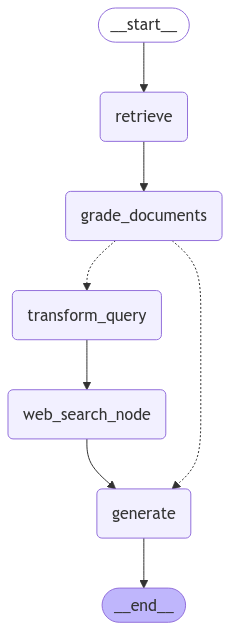

In [15]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

# Use Graph

In [16]:
import uuid

def predict_custom_agent_local_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = app.invoke(
        {"question": example["input"], "steps": []}, config
    )
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}

In [17]:
example = {"input": "What are the types of agent memory?"}
response = predict_custom_agent_local_answer(example)
response

{'response': 'In artificial intelligence agents, the different types of memory include short-term memory, which is used for in-context learning, and long-term memory, which allows the agent to retain and recall information over extended periods, often using an external vector store. Additionally, working memory helps hold information relevant to the current task, while semantic memory stores general knowledge about the world.',
 'steps': ['---RETRIEVE---',
  '---CHECK DOCUMENT RELEVANCE TO QUESTION---',
  '---ASSESS GRADED DOCUMENTS---',
  '---DECISION: DOCUMENTS ARE NOT ALL RELEVANT TO QUESTION, TRANSFORM QUERY---',
  '---TRANSFORM QUERY---',
  '---WEB SEARCH---',
  '---GENERATE---']}